In [1]:
import glob # library to import multiples .csv files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from Functions import import_PV_WT_data, ExpandSOLETE, TimePeriods, PrepareMLmodel, TestMLmodel, get_results, post_process, PV_Performance_Model # Funções disponibilizadas pelo SOLETE

# Importando os dados da base SOLETE

In [2]:
df_5 = pd.read_hdf("Data/Solete/SOLETE_Pombo_5min.h5")
df_60 = pd.read_hdf("Data/Solete/SOLETE_Pombo_60min.h5")
df_short = pd.read_hdf("Data/Solete/SOLETE_short.h5")

In [3]:
print(df_5.shape[0])
print(df_60.shape[0])
print(df_short.shape[0])
print(df_5.columns)


131617
10969
24
Index(['TEMPERATURE[degC]', 'HUMIDITY[%]', 'WIND_SPEED[m1s]', 'WIND_DIR[deg]',
       'GHI[kW1m2]', 'POA Irr[kW1m2]', 'P_Gaia[kW]', 'P_Solar[kW]',
       'Pressure[mbar]'],
      dtype='object')


In [4]:
IRR='POA Irr[kW1m2]'
P = 'P_Solar[kW]'

## Dados do Inversor

In [5]:
def import_PV_WT_data():
    """
    Returns
    -------
    PV : dict
        Holds data regarding the PV string in SYSLAB 715
    WT : dict
        Holds data regarding the Gaia wind turbine

    """
    
    PV={
        "Type": "Poly-cristaline",
        "Az": 60,#deg
        "Estc": 1000, #W/m**2
        "Tstc": 25,#C
        'Pmp_stc' : [165, 125], #W
        'ganma_mp' : [-0.478/100, -0.45/100], #1/K
        'Ns':[18, 6], #int
        'Np':[2, 2], #int
        'a' : [-3.56, -3.56], #module material construction parameters a, b and D_T
        'b' : [-0.0750, -0.0750],
        'D_T' : [3, 3],# represents the difference between the module and cell temperature
                        #these three parameters correspond to glass/cell/polymer sheet with open rack
                        #they are extracted from Sandia document King, Boyson form 2004 page 20
        'eff_P' : [[0, 250, 400, 450, 500, 600, 650, 750, 825, 1000, 1200, 1600, 2000, 3000, 4000,  6000, 8000, 10000],
                   [0, 250, 400, 450, 500, 600, 650, 750, 825, 1000, 1200, 1600, 2000, 3000, 4000,  6000, 8000, 10000]],
        'eff_%' : [[0, 85.5, 90.2, 90.9, 91.8, 92, 92.3, 94, 94.4, 94.8, 95.6, 96, 97.3, 97.7, 98, 98.1, 98.05, 98],
                   [0, 85.5, 90.2, 90.9, 91.8, 92, 92.3, 94, 94.4, 94.8, 95.6, 96, 97.3, 97.7, 98, 98.1, 98.05, 98]],
       "index": ['A','B'], #A and B refer to each channel of the inverter, which has connected a different string.
        }
    
    WT={
        "Type": "Asynchronous",
        "Mode": "Passive, downwind vaning",
        "Pn": 11,#kW
        "Vn": 400,#V
        'CWs' : [3.5, 6, 8, 10, 10.5, 11, 12, 13, 13.4, 14, 16, 18, 20, 22, 24, 25,],#m/s
        'CP' : [0, 5, 8.5, 10.9, 11.2, 11.3, 11.2, 10.5, 10.5, 10, 8.8, 8.7, 8, 7.3, 6.6, 6.3,],#kW
        "Cin": 3.5,#m/s
        "Cout": 25,#m/s
        "HH": 18,#m
        "D": 13,#m
        "SA": 137.7,#m**2
        "B": 2,#int       
        }
    
    return PV, WT

In [6]:
PVinfo, WTinfo = import_PV_WT_data()

# Limpando os dados

In [7]:
#Removendo valores zerados de irradiância
selecao = df_5['POA Irr[kW1m2]'] != 0
print(df_5.shape[0])
df_5 = df_5[selecao]
print(df_5.shape[0])
#df_5 = df_5.reset_index(drop = 'True') #Precisamos resetar o index para a contagem ficar correta e remover a coluna index
print(df_5.head())

131617
81535
                     TEMPERATURE[degC]  HUMIDITY[%]  WIND_SPEED[m1s]  \
2018-06-01 02:05:00          13.058333     0.700000         0.976667   
2018-06-01 02:10:00          12.996667     0.715333         0.850667   
2018-06-01 02:15:00          12.993000     0.700000         0.903667   
2018-06-01 02:20:00          12.949333     0.700000         1.412000   
2018-06-01 02:25:00          13.097667     0.700000         1.369000   

                     WIND_DIR[deg]  GHI[kW1m2]  POA Irr[kW1m2]  P_Gaia[kW]  \
2018-06-01 02:05:00      54.600000    0.000000        0.000390         0.0   
2018-06-01 02:10:00      86.866667    0.000000        0.000987         0.0   
2018-06-01 02:15:00      94.016667    0.000110        0.001000         0.0   
2018-06-01 02:20:00     110.566667    0.000833        0.001530         0.0   
2018-06-01 02:25:00     120.140000    0.001573        0.002130         0.0   

                     P_Solar[kW]  Pressure[mbar]  
2018-06-01 02:05:00     0.003007  

In [8]:
#Removendo valores zerados de irradiância
selecao = df_5[P] != 0
print(df_5.shape[0])
df_5 = df_5[selecao]
print(df_5.shape[0])
#df_5 = df_5.reset_index(drop = 'True') #Precisamos resetar o index para a contagem ficar correta e remover a coluna index
print(df_5.head())

81535
77301
                     TEMPERATURE[degC]  HUMIDITY[%]  WIND_SPEED[m1s]  \
2018-06-01 02:05:00          13.058333     0.700000         0.976667   
2018-06-01 02:10:00          12.996667     0.715333         0.850667   
2018-06-01 02:15:00          12.993000     0.700000         0.903667   
2018-06-01 02:20:00          12.949333     0.700000         1.412000   
2018-06-01 02:25:00          13.097667     0.700000         1.369000   

                     WIND_DIR[deg]  GHI[kW1m2]  POA Irr[kW1m2]  P_Gaia[kW]  \
2018-06-01 02:05:00      54.600000    0.000000        0.000390         0.0   
2018-06-01 02:10:00      86.866667    0.000000        0.000987         0.0   
2018-06-01 02:15:00      94.016667    0.000110        0.001000         0.0   
2018-06-01 02:20:00     110.566667    0.000833        0.001530         0.0   
2018-06-01 02:25:00     120.140000    0.001573        0.002130         0.0   

                     P_Solar[kW]  Pressure[mbar]  
2018-06-01 02:05:00     0.003007   

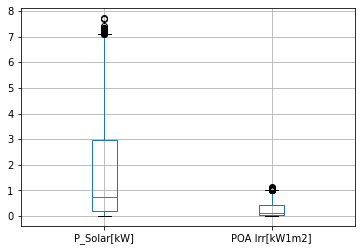

In [9]:
#Verificando outleirs
boxplot = df_5.boxplot(column=[P, IRR])

# Calculando e incluindo os valores de Temperatura do Módulo e PR

In [10]:
Np_a = PVinfo['Np'][0]
Ns_a = PVinfo['Ns'][0]
P_ideal_A = Np_a*Ns_a*PVinfo['Pmp_stc'][0]
P_ideal_A

5940

In [11]:
df_5['PR_A'] = df_5[P] / (P_ideal_A * df_5[IRR] / 1000) # Refazer essa conta do PR pois ela está muito estranha
df_5['PR_A']

2018-06-01 02:05:00    1.297970
2018-06-01 02:10:00    1.298224
2018-06-01 02:15:00    1.298244
2018-06-01 02:20:00    1.298415
2018-06-01 02:25:00    1.297453
                         ...   
2019-08-31 18:30:00    1.252344
2019-08-31 18:35:00    1.252413
2019-08-31 18:40:00    1.252450
2019-08-31 18:45:00    1.252437
2019-08-31 18:50:00    1.252445
Name: PR_A, Length: 77301, dtype: float64

In [12]:
#Calculando a temperatura do módulo
df_5['Pac'], df_5['Pdc'], df_5['TempModule'], df_5['TempCell'] = PV_Performance_Model(df_5, PVinfo)


In [13]:
df_5.head()

,TEMPERATURE[degC],HUMIDITY[%],WIND_SPEED[m1s],WIND_DIR[deg],GHI[kW1m2],POA Irr[kW1m2],P_Gaia[kW],P_Solar[kW],Pressure[mbar],PR_A,Pac,Pdc,TempModule,TempCell
2018-06-01 02:05:00,13.058333,0.700000,0.976667,54.600000,0.000000,0.000390,0.0,0.003007,1016.973673,1.297970,0.003007,0.003065,13.068641,13.069811
2018-06-01 02:10:00,12.996667,0.715333,0.850667,86.866667,0.000000,0.000987,0.0,0.007609,1017.012664,1.298224,0.007609,0.007756,13.022992,13.025952
2018-06-01 02:15:00,12.993000,0.700000,0.903667,94.016667,0.000110,0.001000,0.0,0.007712,1017.079993,1.298244,0.007712,0.007861,13.019575,13.022575
2018-06-01 02:20:00,12.949333,0.700000,1.412000,110.566667,0.000833,0.001530,0.0,0.011800,1017.099976,1.298415,0.011800,0.012029,12.988472,12.993062
2018-06-01 02:25:00,13.097667,0.700000,1.369000,120.140000,0.001573,0.002130,0.0,0.016416,1017.119983,1.297453,0.016416,0.016734,13.152330,13.158720


# Visualizando dados de 5 min

In [14]:
#importando e definindo a função necessária para calcular r²
from scipy import stats
def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return r_value**2

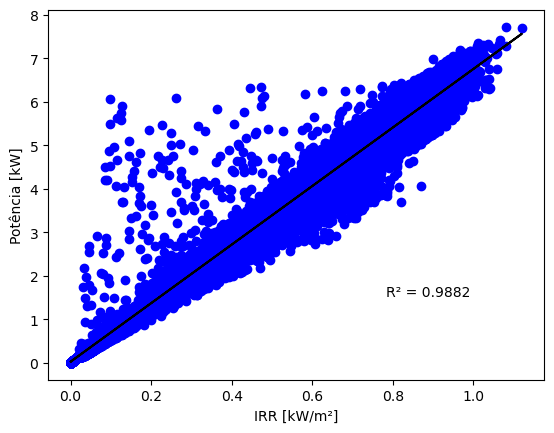

R-square =  0.9882243938563054


In [15]:
#Plotando um gráfico scatter de todos os dias com uma fit line e o R²
plt.scatter(df_5[IRR],df_5[P], color = "blue")
plt.xlabel("IRR [kW/m²]")
plt.ylabel("Potência [kW]")

a, b = np.polyfit(df_5[IRR],df_5[P], 1) #Encontrando a melhor fit line (R²) entre os dois valores
plt.plot(df_5[IRR], a*df_5[IRR]+b, color = "black",)
r2 = rsquared(df_5[IRR],df_5[P])
plt.text(0.7*df_5[IRR].max(), 0.2*df_5[P].max(), 'R² = %0.4f' % r2, color = "black")
plt.show()

print("R-square = ", r2)

## Removendo falhas

In [16]:
limite_sup = 0.61 #Atribuindo um valor de 0.5kW acima e abaixo da fit line para valores de falha
limite_inf = 0.8
selecao_erros = (df_5[P] > a*df_5[IRR]+b + limite_sup) | (df_5[P] < a*df_5[IRR]+b - limite_inf)
df_5_f = df_5[selecao_erros]
df_5_nf = df_5[~selecao_erros]

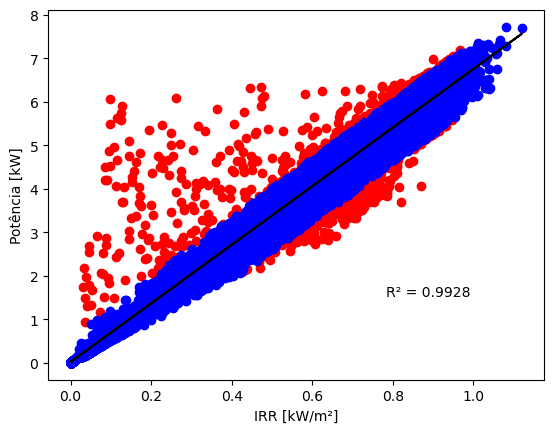

In [17]:
#plotando os valores dentro e fora da faixa definida
plt.scatter(df_5_f[IRR],df_5_f[P], color = "red")
plt.scatter(df_5_nf[IRR],df_5_nf[P], color = 'blue')
plt.xlabel("IRR [kW/m²]")
plt.ylabel("Potência [kW]")

a, b = np.polyfit(df_5_nf[IRR],df_5_nf[P], 1) #Encontrando a melhor fit line entre os dois valores
plt.plot(df_5_nf[IRR], a*df_5_nf[IRR]+b, color = "black",) #Plotando no gráfico a fit line
r2 = rsquared(df_5_nf[IRR],df_5_nf[P])
plt.text(0.7*df_5_nf[IRR].max(), 0.2*df_5_nf[P].max(), 'R² = %0.4f' % r2, color = "black")
plt.show()

In [18]:
print("Falhas = ",df_5_f.shape[0])
print("Não Falhas = ",df_5_nf.shape[0])

Falhas =  593
Não Falhas =  76708


# Visualizando com ajuda da função resample o gráfico dos dados médios por hora

In [19]:
df_resample_60 = df_5.resample("1H").mean()
df_resample_60[P].isna().sum()


3948

In [20]:
#retirando valores NaN
print(df_resample_60.shape[0])
df_resample_60.dropna(inplace = True)
print(df_resample_60.shape[0])

10961
7013


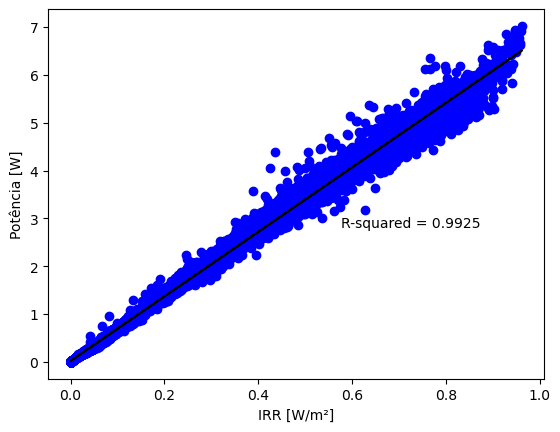

R-square =  0.992460349475611


In [21]:
#Plotando um gráfico scatter de todos os dias com uma fit line e o R²
plt.scatter(df_resample_60[IRR],df_resample_60[P], color = "blue")
plt.xlabel("IRR [W/m²]")
plt.ylabel("Potência [W]")

a, b = np.polyfit(df_resample_60[IRR],df_resample_60[P], 1) #Encontrando a melhor fit line (R²) entre os dois valores
plt.plot(df_resample_60[IRR], a*df_resample_60[IRR]+b, color = "black",)
r2 = rsquared(df_resample_60[IRR],df_resample_60[P])
plt.text(0.6*df_resample_60[IRR].max(), 0.4*df_resample_60[P].max(), 'R-squared = %0.4f' % r2, color = "black")
plt.show()

print("R-square = ", r2)

## Removendo Falhas da medida de 1hora

In [22]:
limite_sup = 0.57 #Atribuindo um valor de 0.5kW acima e abaixo da fit line para valores de falha
limite_inf = 0.75
selecao_erros = (df_resample_60[P] > a*df_resample_60[IRR]+b + limite_sup) | (df_resample_60[P] < a*df_resample_60[IRR]+b - limite_inf)
df_resample_60_f = df_resample_60[selecao_erros]
df_resample_60_nf = df_resample_60[~selecao_erros]

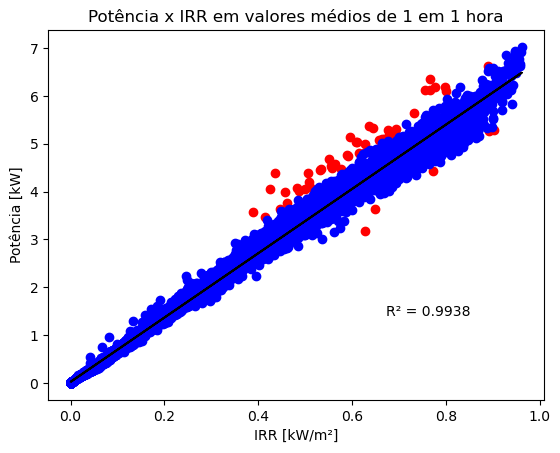

In [23]:
#plotando os valores dentro e fora da faixa definida
plt.scatter(df_resample_60_f[IRR],df_resample_60_f[P], color = "red")
plt.scatter(df_resample_60_nf[IRR],df_resample_60_nf[P], color = 'blue')
plt.xlabel("IRR [kW/m²]")
plt.ylabel("Potência [kW]")

a, b = np.polyfit(df_resample_60_nf[IRR],df_resample_60_nf[P], 1) #Encontrando a melhor fit line entre os dois valores
plt.plot(df_resample_60_nf[IRR], a*df_resample_60_nf[IRR]+b, color = "black",) #Plotando no gráfico a fit line
r2 = rsquared(df_resample_60_nf[IRR],df_resample_60_nf[P])
plt.text(0.7*df_resample_60_nf[IRR].max(), 0.2*df_resample_60_nf[P].max(), 'R² = %0.4f' % r2, color = "black")
plt.title("Potência x IRR em valores médios de 1 em 1 hora")
plt.show()

In [24]:
print("Falhas = ",df_resample_60_f.shape[0])
print("Não Falhas = ",df_resample_60_nf.shape[0])

Falhas =  50
Não Falhas =  6963


# PR semanal

In [25]:
df_resample_1W = df_5.resample("W").sum()

df_resample_1W[P].isna().sum()
df_resample_1W.head()

,TEMPERATURE[degC],HUMIDITY[%],WIND_SPEED[m1s],WIND_DIR[deg],GHI[kW1m2],POA Irr[kW1m2],P_Gaia[kW],P_Solar[kW],Pressure[mbar],PR_A,Pac,Pdc,TempModule,TempCell
2018-06-03,14982.975000,423.265000,1394.329667,153833.593333,216.863623,233.558307,402.695207,1556.297482,6.864038e+05,779.255307,1566.744838,1597.089539,20545.375805,21246.050725
2018-06-10,30913.272000,906.347667,4884.152667,279345.453333,486.801353,498.273597,2314.289610,3422.768267,1.579742e+06,1833.941733,3429.569027,3495.992891,41669.194150,43164.014940
2018-06-17,26188.997794,1029.032667,6244.421992,376015.699654,383.974727,369.714084,5547.407012,2613.499797,1.552736e+06,1891.306454,2621.548856,2672.322993,33768.387764,34877.530016
2018-06-24,25038.883475,1018.956333,8046.101749,410221.089822,431.036217,372.572470,7524.165890,2655.437000,1.547649e+06,1854.459444,2664.657662,2716.266730,32136.491041,33254.208452
2018-07-01,31478.204007,917.781369,4022.884391,364730.926552,557.350214,492.764493,1152.511327,3389.025973,1.603479e+06,1868.803327,3388.473907,3454.101842,42558.029122,44036.322603


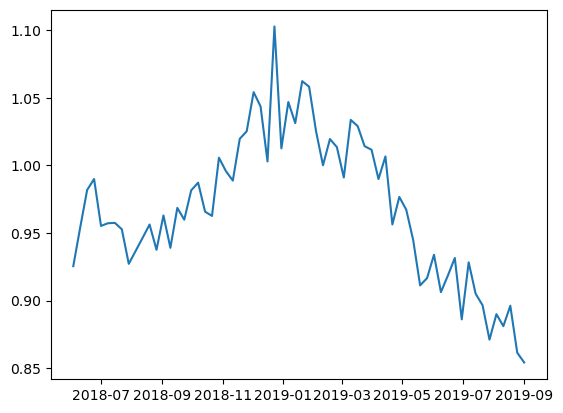

In [29]:
df_resample_1W['PR_A1'] = df_resample_1W[P] / (7200 * df_resample_1W[IRR] / 1000)
plt.plot(df_resample_1W['PR_A1'])


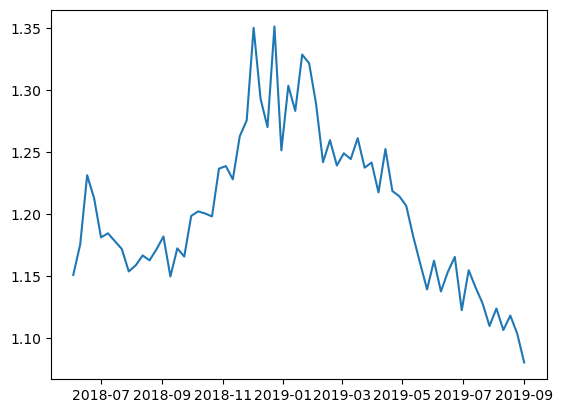

In [30]:
df_resample_1W = df_5.resample("W").mean() #método errado (acredito eu)
plt.plot(df_resample_1W['PR_A'])

In [28]:
df_5['TEMPERATURE[degC]'].max()

43.77090301003351